In [1]:
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')

# import modules
import visualize
import geometry_utils
import dataloader_paths, dataloader_geo

from maritime_traffic_network import MaritimeTrafficNetwork
from random_path_prediction import RandomWalkPathPrediction
import prediction_model_evaluation_metrics as metrics

In [2]:
# Load a model from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_dates = ['202205']
test_dates = ['202206']
DP_tol = 10
min_samples = 13

network_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [3]:
# train model
model = RandomWalkPathPrediction()
model.train(network.G_pruned)
model.G

In [4]:
paths = model.sample_paths(start_node=[130], n_walks=5, n_steps=3)
paths

{(130, 129, 127, 172): 1,
 (130, 4, 353, 319): 1,
 (130, 128, 4, 309): 1,
 (130, 128, 4, 391): 1,
 (130, 127, 126, 228): 1}

In [5]:
out_degrees = dict(network.G.out_degree())
# Calculate the average out-degree
average_out_degree = sum(out_degrees.values()) / len(out_degrees)
print(average_out_degree)

3.9537892791127542


In [6]:
# Load test data from file
path_prefix = '../../data/paths/'
selection_start = 0
selection_end = -1
selection_step = 2
traj_path_prefix = '../../data/processed/'
test_paths = dataloader_paths.load_path_test_data(path_prefix, network_name, test_dates, 
                                                  selection_start, selection_end, selection_step)
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

In [11]:
# MAKE PREDICTIONS
n_start_nodes = 1
n_steps = 2
n_walks = 100
n_predictions = 1
predictions = model.predict(test_paths, n_start_nodes, n_steps, n_predictions, n_walks)
for i in range(0, len(predictions)):
    node_sequence = predictions['prediction'].iloc[i]
    if not geometry_utils.is_valid_path(network.G, node_sequence):
        print(i)

Evaluating 761 samples for next_nodes prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.10 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 623.23m
Median SSPD: 93.28m
Mean choice_accuracy: 0.2503


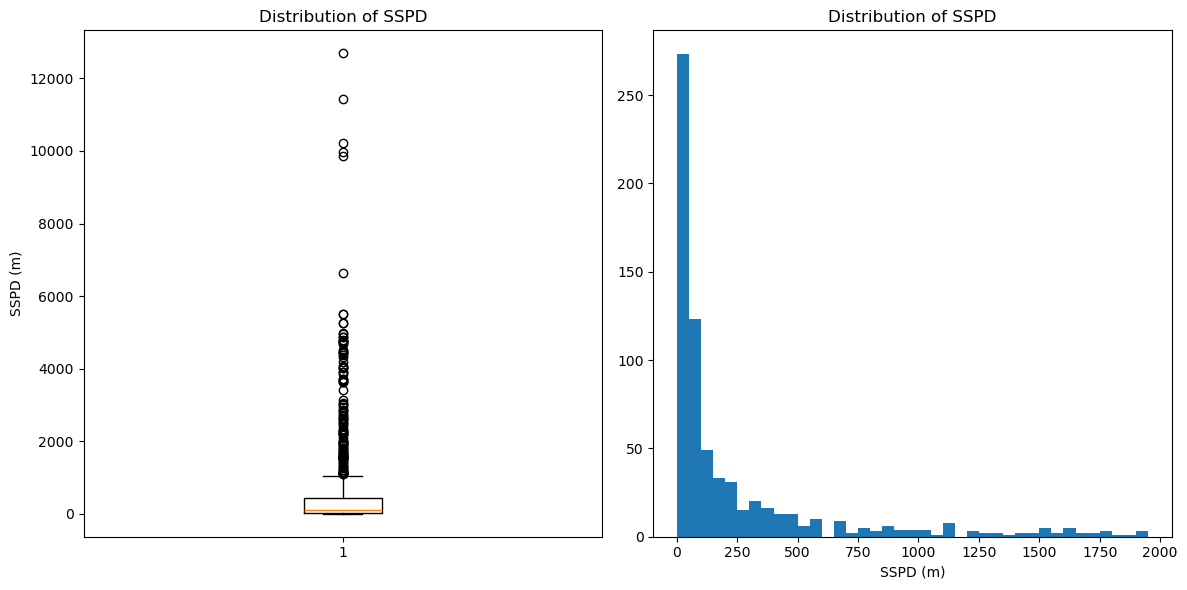

In [12]:
# evaluate
eval_mode = 'trajectory'
evaluation_results, fig = metrics.evaluate_given_predictions('next_nodes', predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, 
                                                             eval_mode=eval_mode)

In [9]:
evaluation_results

,mmsi,true_path,predicted_path,distances,SSPD,choice_accuracy
0,210055000_0_2022-06-01 09:31:46,"(130, 129, 128, 4)","(130, 127, 173, 171)","[102.28028615446812, 99.45181391102521, 92.787...",4392.786168,0.000000
0,210189000_0_2022-06-24 06:55:42,"(185, 180, 179, 178)","(185, 54)","[117.26651104089288, 164.46042975460657, 202.8...",1711.521303,0.000000
0,210189000_8_2022-06-25 16:12:16,"(458, 467, 466, 463)","(458, 467, 466, 463)",[0],0.000000,1.000000
0,211102000_0_2022-06-03 02:00:05,"(366, 352, 359, 374)","(366, 98, 95, 96)","[77.69368972539839, 55.66468529983541, 33.6612...",1696.348979,0.000000
0,211102000_6_2022-06-03 20:10:17,"(465, 464)","(465, 382)","[43.200282942419896, 53.51463694127449, 61.830...",398.296481,0.000000
...,...,...,...,...,...,...
0,314259000_1_2022-06-01 06:38:00,"(184, 180, 179, 178)","(184, 180, 103)","[77.22547944054276, 73.52096088797343, 69.8175...",927.635018,0.333333
0,314318000_10_2022-06-09 02:16:34,"(476, 490, 504, 505)","(476, 409)","[35.30016324993163, 48.15747376089309, 82.8190...",203.091703,0.000000
0,314318000_6_2022-06-08 18:01:01,"(365, 358, 357, 355)","(365, 329, 336, 331)","[60.388358376612075, 66.95742459700902, 75.600...",52.960493,0.000000
0,314631000_0_2022-06-09 14:42:08,"(185, 180, 179, 178)","(185, 54)","[6.464965575569832, 54.25288393496657, 138.917...",1612.219552,0.000000


In [10]:
# make predictions with the Dijkstra model and plot
i = 0
example = test_paths.iloc[i]
mmsi = example.mmsi
start_node = [example.path[0], example.path[1]]
end_node = example.path[-1]
true_path = example.path
trajectory = test_trajectories.get_trajectory(mmsi)

predictions, flag = model.predict_path(start_node[-1], end_node)
predictions = start_node[:-1] + predictions
predictions = {tuple(predictions):1}

map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location=location, end_node=end_node)
map.save('../../reports/maps/'+network_name+'_random_predictions.html')
print(f'Map saved under {"../../reports/maps/"+network_name+"_random_predictions.html"}')

AttributeError: 'RandomWalkPathPrediction' object has no attribute 'predict_path'